In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import torch

# Load the data
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

# Convert y_train and y_test to numpy arrays
y_train = y_train['Diagnosis'].values
y_test = y_test['Diagnosis'].values

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (455, 30)
Testing data shape: (114, 30)


In [21]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to numpy arrays
X_train_scaled = np.array(X_train_scaled)
X_test_scaled = np.array(X_test_scaled)

In [22]:
# Initialize TabNet classifier
tabnet_model = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_idxs=[], cat_dims=[],  # No categorical features in this dataset
    lambda_sparse=1e-3, optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax',
    scheduler_params=dict(mode="min", patience=5, min_lr=1e-5, factor=0.9),
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    verbose=10
)

# Fit the model
tabnet_model.fit(
    X_train=X_train_scaled, y_train=y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=100,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

/Users/guna/Downloads/TabNet/.venv/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.21856 | train_auc: 0.71107 | valid_auc: 0.76482 |  0:00:00s
epoch 10 | loss: 0.15736 | train_auc: 0.98852 | valid_auc: 0.99705 |  0:00:01s

Early stopping occurred at epoch 19 with best_epoch = 9 and best_valid_auc = 0.99803


/Users/guna/Downloads/TabNet/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [23]:
# Make predictions
y_pred = tabnet_model.predict(X_test_scaled)
y_pred_proba = tabnet_model.predict_proba(X_test_scaled)

# Calculate accuracy and AUC
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba[:, 1])

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")

Accuracy: 0.9825
AUC: 0.9980


               feature  importance
20             radius3    0.141114
26          concavity3    0.085699
22          perimeter3    0.078722
6           concavity1    0.074255
8            symmetry1    0.043406
7      concave_points1    0.042611
12          perimeter2    0.039953
23               area3    0.039093
5         compactness1    0.039070
27     concave_points3    0.038895
28           symmetry3    0.038732
2           perimeter1    0.035233
15        compactness2    0.031534
11            texture2    0.029994
9   fractal_dimension1    0.027756
18           symmetry2    0.025861
25        compactness3    0.024415
4          smoothness1    0.020885
24         smoothness3    0.017239
13               area2    0.014560
17     concave_points2    0.014442
10             radius2    0.013999
3                area1    0.013936
14         smoothness2    0.013132
1             texture1    0.013023
19  fractal_dimension2    0.011078
16          concavity2    0.010689
29  fractal_dimensio

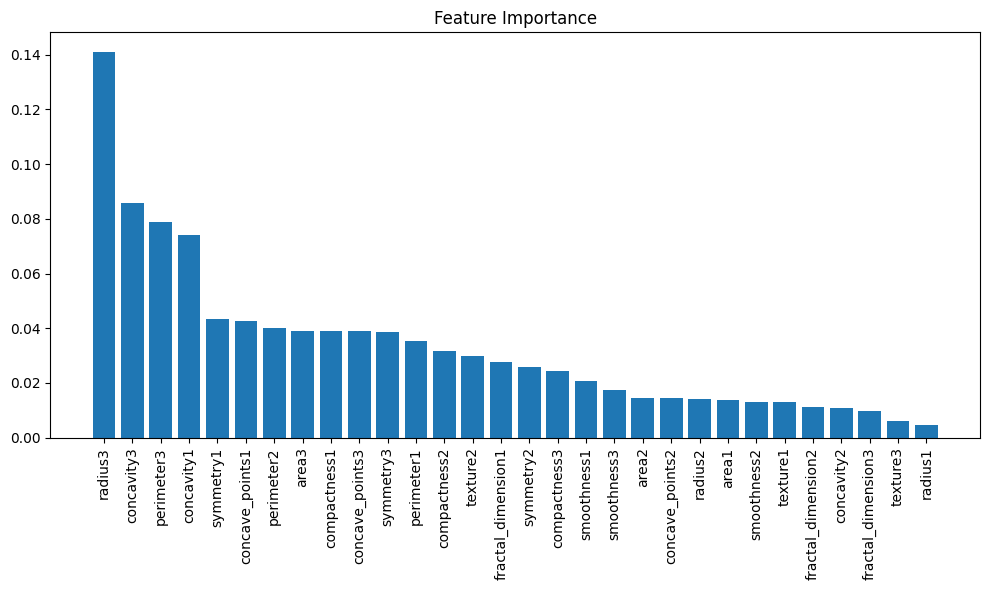

In [24]:
# Get feature importance
feature_importance = tabnet_model.feature_importances_

# Create a dataframe of feature importances
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importance
})

# Sort by importance
importance_df = importance_df.sort_values('importance', ascending=False)

print(importance_df)

# Visualize feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(importance_df['feature'], importance_df['importance'])
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()